In [1]:
 '''
Author information:
Joey R. Muffoletto
University of Texas at Austin
Autonomous Systems Group
jrmuff@utexas.edu
'''

'\nAuthor information:\nJoey R. Muffoletto\nUniversity of Texas at Austin\nAutonomous Systems Group\njrmuff@utexas.edu\n'

In [2]:
import os

import realtime_manager as rm 
import graph_manager as gm
import reworked_graph as rg
import copy

# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

In [3]:
'''
manager configurations

traffic test globals
'''
MIN_TOWERS = 2
NUM_TOWERS = 8
TAU_MAX = 8
TAU = 0

FREQUENCY_MULTIPLIERS = [.25, .5, 1]
FREQUENCY_MULTIPLIER = 1

LOW_TRAFFIC_MULTIPLIER = 1
HIGH_TRAFFIC_MULTIPLIER = 3

MIN_LOW_TRAFFIC = 0
MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_TOWERS * FREQUENCY_MULTIPLIER)

MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_TOWERS * FREQUENCY_MULTIPLIER)

MIN_TTL = 0
MAX_TTL = 7


DEFAULT_EMPTY_STATE = rg.State((),(),{"0" : 6})
rm.configure_realtime(tau=TAU, override_default_empty_state=DEFAULT_EMPTY_STATE)

# HIGH_TRAFFIC_FREQUENCY = .1 # use rand.random() = [0.0, 1.0], or, just add this value until = 1 then reset
HIGH_TRAFFIC_TRIGGER = 8
NUM_TIME_STEPS = 40



In [4]:
'''
Input generation functions

low traffic is some random number between min_low_traffic and max_low_traffic, high traffic is the same with high

choose a random tower index everytime we add one

high traffic occurs everytime HIGH_TRAFFIC_FREQUENCY * TIME_STEPS is a whole number

TTL is a random number between MIN_TTL and MAX_TTL
'''
import random
random.seed(10)
def generate_traffic(min_traffic, max_traffic):
    additional_requests_dict = dict()
#     counter = 0
    requests_to_add = random.randint(min_traffic, max_traffic)
    for i in range(requests_to_add):
#         if counter == NUM_TOWERS:
#             counter = 0
#         tower_to_add_to = counter
#         counter+=1
        tower_to_add_to = random.randint(0, NUM_TOWERS-1) # NUM_TOWERS is OOB
        request_to_add = ('no_pref', random.randint(MIN_TTL, MAX_TTL))
#         request_to_add = ('no_pref', 5)
        if tower_to_add_to in additional_requests_dict:
            additional_requests_dict[tower_to_add_to].append(request_to_add)
        else:
            additional_requests_dict[tower_to_add_to] = [request_to_add]
    return additional_requests_dict
            
def generate_low_traffic():
    return generate_traffic(MIN_LOW_TRAFFIC, MAX_LOW_TRAFFIC)
    
def generate_high_traffic():
    return generate_traffic(MIN_HIGH_TRAFFIC, MAX_HIGH_TRAFFIC)

In [5]:
'''
Input Generation
'''
def generate_inputs():
    input = []
    high_traffic_counter = 1
    for time in range(NUM_TIME_STEPS):
        if high_traffic_counter == HIGH_TRAFFIC_TRIGGER:
            high_traffic_counter = 1
            input.append([generate_high_traffic()])
        else:
            high_traffic_counter += 1
            input.append([generate_low_traffic()])

    initial_system = [copy.deepcopy(gm.return_tower(0, 1, [],[6])) for i in range(NUM_TOWERS)]
    return initial_system, input

In [6]:
'''
Input statistics:
'''
def generate_input_statistics(input):
    requests_per_tower = [0 for i in range(NUM_TOWERS)]
    for time_step in range(len(input)):
        for i in range(NUM_TOWERS):
            if i in input[time_step][0]:
                requests_per_tower[i]+=len(input[time_step][0][i])
    for i in range(NUM_TOWERS):
        print("tower " + str(i) + "has " + str(requests_per_tower[i]) + " requests")
    average_input_frequency = sum([i for i in requests_per_tower])/(float(NUM_TIME_STEPS) * float(NUM_TOWERS))
    print("average_input_frequency = " + str(average_input_frequency))
    return average_input_frequency

In [7]:
# '''
# INPUT SAVING
# '''
# input_copy = copy.deepcopy(input)
# # for _dict in input_copy:
# #     print(_dict)

# initial_system_copy = copy.deepcopy(initial_system)

In [8]:
'''
data collection functions
'''
def run_realtime_data_collection(initial_system_copy, input_copy):
    _completed_states_per_tau = [[] for i in range(TAU_MAX)]
    _timing_info_per_tau = [[] for i in range(TAU_MAX)]
    for _tau in range(TAU_MAX):
        rm.configure_realtime(tau=_tau, override_default_empty_state=DEFAULT_EMPTY_STATE)
        traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy))
        _completed_states_per_tau[_tau] = copy.deepcopy(traces)
        _timing_info_per_tau[_tau] = copy.deepcopy(timings)
        gm.reset_globals()
    return _completed_states_per_tau, _timing_info_per_tau
    #     print(traces)
        # _completed_states, _timing_info = rm.main_loop(initial_system_copy, input_copy)


In [9]:
'''
data collection pipeline
'''
NUM_TRIALS = 5
for freq in FREQUENCY_MULTIPLIERS:
    # setting the frequency multipliers
    MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_TOWERS * freq)

    MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
    MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_TOWERS * freq)    
    for i in range(NUM_TRIALS):
        initial_system, input = generate_inputs()
        input_frequency = generate_input_statistics(input) 
        _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(input))
        break
    break

tower 0has 4 requests
tower 1has 4 requests
tower 2has 13 requests
tower 3has 1 requests
tower 4has 5 requests
tower 5has 8 requests
tower 6has 7 requests
tower 7has 13 requests
average_input_frequency = 0.171875
additional requests for tower 0 = [('no_pref', 6)]
[('no_pref', 6)]
additional requests for tower 7 = [('no_pref', 0)]
[('no_pref', 0)]
Tower has requests :: ['no_pref'] and times of [6] and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: ['no_pref'] and times of [0] and ports of {'0': 6}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
], [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State c

cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1,

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.238545633998001
	round 0 breakdown :: 
	 tower 0 took 6.925001798663288e-06 to find most expensive request and took 0.012657457002205774 to synthesize with published request
	 tower 1 took 2.8089998522773385e-06 to find most expensive request and took 0.025682893981866073 to synthesize with published request
	 tower 2 took 0.0020712160039693117 to find most expensive request and took 0.026388385995232966 to synthesize with published request
	 tower 3 took 2.9810034902766347e-06 to find most expensive request and took 0.022428467993449885 to synthesize with published request
	 tower 4 took 0.00208634899900062 to find most expensive request and took 0.025422201004403178 to synthesize with published request
	 tower 5 took 0.007403363000776153 to find most expensive request and took 0.045466110001143534 to synthes

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]

 new round - completed in time 0.21013742999639362
	round 0 breakdown :: 
	 tower 0 took 1.926400000229478e-05 to find most expensive request and took 0.00936992700007977 to synthesize with published request
	 tower 1 took 3.330002073198557e-06 to find most expensive request and took 0.023643397995328996 to synthesize with published request
	 tower 2 took 0.004678958997828886 to find most expensive request and took 0.025642898996011354 to synthesize with published request
	 tower 3 took 1.5165998775046319e-05 to find most expensive request and took 0.0214076

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17867559899605112
	round 0 breakdown :: 
	 tower 0 took 0.002112469002895523 to find most expensive request and took 0.0028857569996034727 to synthesize with published request
	 tower 1 took 8.037997758947313e-06 to find most expensive request and took 0.020245184008672368 to synthesize with published request
	 tower 2 took 4.920002538710833e-06 to find most expensive request and took 0.021182388001761865 to synthesize with published request
	 tower 3 took 4.276000254321843e-06 to find most expensive request and took 0.043564159008383285 to synthesize with published request
	 tower 4 took 3.5990015021525323e-06 to find most expensive request and took 0.017974923001020

]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Tim

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17504477300099097
	round 0 breakdown :: 
	 tower 0 took 6.9590023485943675e-06 to find most expensive request and took 0.006222557000000961 to synthesize with published request
	 tower 1 took 5.109999619890004e-06 to find most expensive request and took 0.019493154999508988 to synthesize with published request
	 tower 2 took 0.002055547993222717 to find most expensive request and too

Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting reques

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1505417230000603
	round 0 breakdown :: 
	 tower 0 took 1.876099850051105e-05 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 6.145004590507597e-06 to find most expensive request and took 0.023919586012198124 to synthesize with published request
	 tower 2 took 1.4240002201404423e-05 to find most expensive request and 

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13651458000094863
	round 0 breakdown :: 
	 tower 0 took 8.064002031460404e-06 to find most expensive request and took 0.0020069720048923045 to synthesize with published request
	 tower 1 took 2.7710048016160727e-06 to find most expensive request and took 0.01624025501223514 to synthesize with published request
	 tower 2 took 2.4230030248872936e-06 to find most expensive request and took 0.020166832000541035 to synthesize with published request
	 tower 3 took 0.0029022959934081882 to find most expensive request and took 0.0232

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1686852019993239
	round 0 breakdown :: 
	 tower 0 took 7.162001566030085e-06 to find most expensive request and took 0.005157141997187864 to synthesize with published request
	 tower 1 took 2.7909991331398487e-06 to find most expensive request and took 0.018110597986378707 to synthesize with published request
	 tower 2 took 0.002158037998015061 to find most expensive request and took 0.022694766012136824 to synthesize with published request
	 tower 3 took 6.094000127632171e-06 to find most expensive request and took 0.017364848012221046 to synthesize with published request
	 tower 4 took 0.00951096700009657 to find most expensive request and took 0.03496974000154296 to synthesize with published request
	 tower 5 took 1.070399594027549e-05 to find most expensive request and took 0.019643088009615894 to synthesi

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1291211120042135
	round 0 breakdown :: 
	 tower 0 took 7.795999408699572e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.911001502070576e-06 to find most expensive request and took 0.016297952002787497 to synthesize with published request
	 tower 2 took 2.5229965103790164e-06 to find most expensive request and took 0.01650299000175437 to synthesize with published request
	 tower 3 took 2.505999873392284e-06 to find most expensive request and took 0.0185

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17405698200309416
	round 0 breakdown :: 
	 tower 0 took 0.0022187520007719286 to find most expensive request and took 0.03370561400515726 to synthesize with published request
	 tower 1 took 3.1122996006160975e-05 to find most expensive request and took 0.022263634993578307 to synthesize with published request
	 tower 2 took 3.7040008464828134e-06 to find most expensive request and took 0.018308145008631982 to synthesize with published request
	 tower 3 took 2.573004167061299e-06 to find most expensive request and took 0.017778443005227018 to synthesize with published request
	 tower 4 took 2.4900000425986946e-06 to find most expensive request and took 0.017639592013438232 to synthesize with published request
	 tower 5 took 0.002120518998708576 to find most expensive request and took 0.02064024800347397 to synt

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13762112399854232
	round 0 breakdown :: 
	 tower 0 took 6.87500141793862e-06 to find most expensive request and took 0.0022057020032661967 to synthesize with published request
	 tower 1 took 2.6740017347037792e-06 to find most expensive requ

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16100680999807082
	round 0 breakdown :: 
	 tower 0 took 8.203998731914908e-06 to find most expensive request and took 0.00469157200132031 to synthesize with published request
	 tower 1 took 2.7240021154284477e-06 to find most expensive request and took 0.018545660008385312 to synthesize with published request
	 tower 2 took 4.330399679020047e-05 to find most expensive request and took 0.02410032699117437 to synthesize with published request
	 tower 3 took 2.634005795698613e-06 to find most expensive request and took 0.022069942009693477 to synthesize with published request
	 tower 4 took 4.4199987314641476e-06 to find most expensive request and took 0.0198457160004181

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1970192790031433
	round 0 breakdown :: 
	 tower 0 took 1.03089987533167e-05 to find most expensive request and took 0.008681992992933374 to synthesize with published request
	 tower 1 took 3.2509997254237533e-06 to find most expensive request and took 0.017200458998559043 to synthesize with published request
	 tower 2 took 0.007471941004041582 to find most expensive request and took 0.03766058300243458 to synthesize with published request
	 tower 3 took 3.510998794808984e-06 to find most expensive request and took 0.01797872699535219 to synthesize with published request
	 tower 4 took 0.00236443000176223 to find most expensive request and took 0.023075766002875753 to 

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (5,) Port states of :: {'0': 3} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 2} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[1, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15063038400694495
	round 0 breakdown :: 
	 tower 0 took 0.0019338550046086311 to find most expensive request and took 0.002354195006773807 to synthesize with published request
	 tower 1 took 8.132799848681316e-05 to find most expensive reque

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14036738900176715
	round 0 breakdown :: 
	 tower 0 took 1.2933000107295811e-05 to find most expensive request and took 0.002032581003732048 to synthesize with published request
	 tower 1 took 0.002790280996123329 to find most expensive request and took 0.020830943998589646 to synthesize with published request
	 tower 2 took 3.5510020097717643e-06 to find most expensive request and took 0.018255467992275953 to synthesize with published request
	 tower 3 took 2.677996235433966e-06 to find most expensive request and took 0.02295492301345803 to synthesize with published request
	 tower 4 took 2.4800028768368065e-06 to find most expensive request and took 0.017937216005520895 to synthesize with published request
	 tower 5 took 2.772998414002359e-06 to find most expensive request and took 0.01885301899892511 to synt

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14067259299918078
	round 0 breakdown :: 
	 tower 0 took 6.984999345149845e-06 to find most expensive request and took 0.004188578997855075 to synthesize with published request
	 tower 1 took 2.7469941414892673e-06 to find most expensive requ

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17495429900009185
	round 0 breakdown :: 
	 tower 0 took 9.092997061088681e-06 to find most expensive request and took 0.012231717009854037 to synthesize with published request
	 tower 1 took 4.460998752620071e-06 to find most expensive request and took 0.018212481001683045 to synthesize with published request
	 tower 2 took 0.003783553998800926 to find most expensive request and took 0.024174822006898466 to synthesize with published request
	 tower 3 took 4.086999979335815e-06 to find most expensive request and took 0.0183393

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2]]

 new round - completed in time 0.16996528900199337
	round 0 breakdown :: 
	 tower 0 took 0.0021229049962130375 to find most expensive request and took 0.0031573329979437403 to synthesize with published request
	 tower 1 took 1.0032003046944737e-05 to find most expensive request and took 0.020656110005802475 to synthesize with published request
	 tower 2 took 3.198001650162041e-06 to find most expensive request and took 0.04363714800274465 to synthesize with published request
	 tower 3 took 2.569002390373498e-06 to find most expensive request and took 0.01746201700734673 to synthesize with published request
	 tower 4 took 2.472996129654348e-06 to find most expensive request and took 0.018564323014288675 to synthesize with published request
	 tower 5 took 2.36400228459388e-06 to find most expensive request and took 0.018663472001207992 to synth

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14259426300122868
	round 0 breakdown :: 
	 tower 0 took 7.021997589617968e-06 to find most expensive request and took 0.002024509994953405 to synthesize with published request
	 tower 1 took 2.6619964046403766e-06 to find most expensive request and took 0.01678300800267607 to synthesize with published request
	 tower 2 took 2.369000867474824e-06 to find most expensive request and took 0.01719525699445512 to synthesize with published request
	 tower 3 took 2.3219981812871993e-06 to find most expensive request and took 0.018907

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1638444510026602
	round 0 breakdown :: 
	 tower 0 took 2.4638997274450958e-05 to find most expensive request and took 0.008612124998762738 to synthesize with published request
	 tower 1 took 2.8799986466765404e-06 to find most expensive request and took 0.020508869005425368 to synthesize with published request
	 tower 2 took 0.002259995002532378 to find most expensive request and took 0.02330980898841517 to synthesize with published request
	 tower 3 took 3.3710020943544805e-06 to find most expensive request and took 0.02092817099764943 to synthesize with published request
	 tower 4 took 1.9148996216244996e-05 to find most expensive request and took 0.019014792989764828 to synthesize with published request
	 tower 5 took 2.562999725341797e-06 to find most expensive request and took 0.019181370989826974 to synt

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1445750240018242
	round 0 breakdown :: 
	 tower 0 took 7.137001375667751e-06 to find most expensive request and took 0.004373499992652796 to synthesize with published request
	 tower 1 took 2.683002094272524e-06 to find most expensive request and took 0.017206131007696968 to synthesize with published request
	 tower 2 took 2.42000533035025e-06 to find most expensive request and took 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.18790457599970978
	round 0 breakdown :: 
	 tower 0 took 2.4658002075739205e-05 to find most expensive request and took 0.012349222000921145 to synthesize with published request
	 tower 1 took 2.8229987947270274e-06 to find most expensive request and took 0.018245181985548697 to synthesize with published request
	 tower 2 took 0.003518049001286272 to find most expensive request and took 0.020607974009180907 to synthesize with published request
	 tower 3 took 6.080001185182482e-06 to find most expensive request and took 0.01925

]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (0,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0'

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1391830420034239
	round 0 breakdown :: 
	 tower 0 took 7.005997758824378e-06 to find most expensive request and took 0.0022481150008388795 to synthesize with published request
	 tower 1 took 2.7889982447959483e-06 to find most expensive requ

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13782750300015323
	round 0 breakdown :: 
	 tower 0 took 1.0849995305761695e-05 to find most expensive request and took 0.0019320249994052574 to synthesize with published request
	 tower 1 took 2.8909998945891857e-06 to find most expensive request and took 0.01640799799497472 to synthesize with published request
	 tower 2 took 2.5670015020295978e-06 to find most expensive request and took 0.018820883000444155 to synthesize with published request
	 tower 3 took 2.624998160172254e-06 to find most expensive request and took 0.017551745011587627 to synthesize with published request
	 tower 4 took 6.989997928030789e-06 to find most expensive request and took 0.0212749209895

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13178045499807922
	round 0 breakdown :: 
	 tower 0 took 7.636001100763679e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.9290022212080657e-06 to find most expensive r

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15330482499848586
	round 0 breakdown :: 
	 tower 0 took 2.238199522253126e-05 to find most expensive request and took 0.004900300002191216 to synthesize with published request
	 tower 1 took 0.0026466839990462177 to find most expensive request and took 0.021174706002057064 to synthesize with published request
	 tower 2 took 3.3859978429973125e-06 to find most expensive request and took 0.02019251098681707 to synthesize with published request
	 tower 3 took 2.606997441034764e-06 to find most expensive request and took 0.01884233098826371 to synthesize with published request
	 tower 4 took 2.654000127222389e-06 to find most expensive request and took 0.01877682199847186

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, Sta

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13787797699478688
	round 0 breakdown :: 
	 tower 0 took 7.044000085443258e-06 to find most expen

Tower has requests :: ['no_pref'] and times of [4] and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13697428700106684
	round 0 breakdown :: 
	 tower 0 took 7.588998414576054e-06 to find most expensive request and took 0.00259760699555045 to synthesize with published request
	 tower 1 took 3.715998900588602e-06 to find most expensive request and took 0.01714609299233416 to synthesize with published request
	 tower 2 took 3.592002030927688e-06 to find most expensive request and took 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16532868700596737
	round 0 breakdown :: 
	 tower 0 took 7.525995897594839e-06 to find most expensive request and took 0.004320760002883617 to synthesize with published request
	 tower 1 took 2.668995875865221e-06 to find most expensive request and took 0.017031759991368745 to synthesize with published request
	 tower 2 took 0.0025941380008589476 to find most expensive request and took 0.02267806300369557 to synthesize with published request
	 tower 3 took 3.2379975891672075e-06 to find most expensive request and took 0.01892949500324903 to synthesize with published request
	 tower 4 took 0.009004882005683612 to find most expensive request and took 0.032084142992971465 to synthesize with published request
	 tower 5 took 4.539004294201732e-06 to find most expensive request and took 0.02004125900566578 to synthes

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13205372099764645
	round 0 breakdown :: 
	 tower 0 took 7.07699655322358e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.7899950509890914e-06 to find most expensive request and took 0.017376776988385245 to synthesize with published request
	 tower 2 took 2.4569962988607585e-06 to find most expensive request and took 0.017102914986026008 to synthesize with published request
	 tower 3 took 2.373002644162625e-06 to find most expensive request and took 0.0216621350045898 to synthesize with published request
	 tower 4 took 2.34400067711249e-06 to find most expensive request and took 0.018972939004015643 to synthesize with published request
	 tower 5 took 2.621993189677596e-06 to find most expensive request and took 0.0182468639977742 to synth

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14158197999495314
	round 0 breakdown :: 
	 tower 0 took 7.0160022005438805e-06 to find most expensive request and took 0.003121489004115574 to synthesize with published request
	 tower 1 took 2.8900030883960426e-06 to find most expensive request and took 0.01753777600970352 to synthesize with published request
	 tower 2 took 2.8860013117082417e-06 to find most expensive request and t

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], 

Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 4}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13441165100084618
	round 0 breakdown :: 
	 tower 0 took 0.0020021000018459745 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 8.638002327643335e-06 to find most expensive request and took 0.01892523699643789 to synthesize with published request
	 tower 2 took 4.476001777220517e-06 to find most expensive request and took 0.017388496999046765 to synthesize with published request
	 tower 3 took 2.9090006137266755e-06 to find most expensive request and took 0.018

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12699851700017462
	round 0 breakdown :: 
	 tower 0 took 7.241003913804889e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.7230053092353046e-06 to find most expensive request and took 0.01656381000066176 to synthesize with published request
	 tower 2 took 2.392996975686401e-06 to find most expensive request and took 0.01627012199605815 to synthesize with published request
	 tower 3 took 2.216002030763775e-06 to find most expensive request and took 0.020267815991246607 to synthesize with published request
	 tower 4 took 2.5550034479238093e-06 to find most expensive request and took 0.0188091570089

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1854537459948915
	round 0 breakdown :: 
	 tower 0 took 7.438000466208905e-06 to find most expensive request and took 0.0042491570056881756 to synthesize with published request
	 tower 1 took 2.9289949452504516e-06 to find most expensive request and took 0.050244768004631624 to synthesize with published request
	 tower 2 took 0.0020324159995652735 to find most expensive request and took 0.021426277999125887 to synthesize with published request
	 tower 3 took 3.6560013541020453e-06 to find most expensive request and took 0.021705730985559057 to synthesize with published request
	 tower 4 took 2.683002094272524e-06 to find most expensive request and took 0.020267817009880673 to synthesize with published request
	 tower 5 took 3.159999323543161e-06 to find most expensive request and took 0.017014396995364223 to sy

additional requests for tower 0 = [('no_pref', 6)]
additional requests for tower 7 = [('no_pref', 0)]
Tower has requests :: ['no_pref'] and times of [6] and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: ['no_pref'] and times of [0] and ports of {'0': 6}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12813619699591072
	round 0 breakdown :: 
	 tower 0 took 7.378999725915492e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.887005393858999e-06 to find most expensive re

]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (5,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time s

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.135421363003843
	round 0 breakdown :: 
	 tower 0 took 6.909998774062842e-06 to find most expensi

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1498581310006557
	round 0 breakdown :: 
	 tower 0 took 7.0259993663057685e-06 to find most expensive request and took 0.005748080999183003 to synthesize with published request
	 tower 1 took 2.754000888671726e-06 to find most expensive request and took 0.016895402994123287 to synthesize with published request
	 tower 2 took 2.4900000425986946e-06 to find most expensive request and took 0.01616232199012302 to synthesize with published request
	 tower 3 took 2.4559994926676154e-06 to find most expensive request and took 0.01785

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.18181272500078194
	round 0 breakdown :: 
	 tower 0 took 7.137998181860894e-06 to find most expensive request and took 0.011361292003130075 to synthesize with published request
	 tower 1 took 2.6859997888095677e-06 to find most expensive request and took 0.017225497002073098 to synthesize with published request
	 tower 2 took 0.002934814001491759 to find most expensive request and took 0.022552619011548813 to synthesize with published request
	 tower 3 took 7.118003850337118e-06 to find most expensive request and took 0.01694999900064431 to synthesize with published request
	 tower 4 took 0.0026128699973924085 to find most expensive request and took 0.02043098500143969

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15379757800110383
	round 0 breakdown :: 
	 tower 0 took 3.6797995562665164e-05 to find most expensive request and took 0.0025993270028266124 to synthesize with published request
	 tower 1 took 3.078996087424457e-06 to find most expensive request and took 0.021599749983579386 to synthesize with published request
	 tower 2 took 2.5040062610059977e-06 to find most expensive request and 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13455869800236542
	round 0 breakdown :: 
	 tower 0 took 3.573299909476191e-05 to find most expensive request and took 0.0021096019991091453 to synthesize with published request
	 tower 1 took 3.0860028346069157e-06 to find most expensive request and took 0.016717947997676674 to synthesize with published request
	 tower 2 took 2.5460030883550644e-06 to find most expensive request and took 0.01679952600534307 to synthesize with published request
	 tower 3 took 2.911998308263719e-06 to find most expensive request and took 0.01726214600057574 to synthesize with published request
	 tower 4 took 2.672997652553022e-06 to find most expensive request and took 0.018863938996219076 to synthesize with published request
	 tower 5 took 2.730004780460149e-06 to find most expensive request and took 0.017808816002798267 to syn

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15673140100261662
	round 0 breakdown :: 
	 tower 0 took 1.3962999219074845e-05 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.888002200052142e-06 to find most expensive r

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (5,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16290714099886827
	round 0 breakdown :: 
	 tower 0 took 7.0780006353743374e-06 to find most expensive request and took 0.0025935720041161403 to synthesize with published request
	 tower 1 took 2.7319983928464353e-06 to find most expensive re

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12947464099852368
	round 0 breakdown :: 
	 tower 0 took 7.979004294611514e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.8479989850893617e-06 to find most expensive request and took 0.016652028003591113 to synthesize with published request
	 tower 2 took 2.4280016077682376e-06 to find most expensive request and took 0.017282413005887065 to synthesize with published request
	 tower 3 took 2.4089968064799905e-06 to find most expensive request and took 0.022262186990701593 to synthesize with published request
	 tower 4 took 2.3130050976760685e-06 to find most expensive request and took 0.01998755800741492 to synthesize with published request
	 tower 5 took 2.4519977159798145e-06 to find most expensive request and took 0.01804656199965393 t

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14890352499787696
	round 0 breakdown :: 
	 tower 0 took 2.5162000383716077e-05 to find most expensive request and took 0.0022578529969905503 to synthesize with published request
	 tower 1 took 2.892003976739943e-06 to find most expensive req

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14194537999719614
	round 0 breakdown :: 
	 tower 0 took 7.861002814024687e-06 to find most expensive request and took 0.0034021149986074306 to synthesize with published request
	 tower 1 took 2.782995579764247e-06 to find most expensive request and took 0.020369194993691053 to synthesize with published request
	 tower 2 took 2.4319961084984243e-06 to find most expensive request and took 0.016688117997546215 to synthesize with published request
	 tower 3 took 2.2899985197000206e-06 to find most expensive request and took 0.017980082979192957 to synthesize with published request
	 tower 4 took 2.392000169493258e-06 to find most expensive request and took 0.0180248579927

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15107226699910825
	round 0 breakdown :: 
	 tower 0 took 7.6129945227876306e-06 to find most expensive request and took 0.004629276008927263 to synthesize with published request
	 tower 1 took 2.7620044420473278e-06 to find most expensive req

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13906286400015233
	round 0 breakdown :: 
	 tower 0 took 1.2500997399911284e-05 to find most expensive request and took 0.0021135830029379576 to synthesize with published request
	 tower 1 took 2.982000296469778e-06 to find most expensive request and took 0.016030160993977915 to synthesize with published request
	 tower 2 took 2.4859982659108937e-06 to find most expensive request and took 0.017897536992677487 to synthesize with published request
	 tower 3 took 2.4230030248872936e-06 to find most expensive request and took 0.0179549099993892 to synthesize with published request
	 tower 4 took 3.1109957490116358e-06 to find most expensive request and took 0.021857633997569792 to synthesize with published request
	 tower 5 took 2.5280023692175746e-06 to find most expensive request and took 0.01978495199000463 to s

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12838547600404127
	round 0 breakdown :: 
	 tower 0 took 7.357994036283344e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 3.040993760805577e-06 to find most expensive request and took 0.01729218898981344 to synthesize with published request
	 tower 2 took 2.4649998522363603e-06 to find most expensive request and took 0.016128232011396904 to synthesize with published request
	 tower 3 took 2.396998752374202e-06 to find most expensive request and took 0.01924906599742826 to synthesize with published request
	 tower 4 took 2.1889936760999262e-06 to find most expensive request and took 0.0166940880008

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.20062953799788374
	round 0 breakdown :: 
	 tower 0 took 7.123002433218062e-06 to find most expensive request

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16707952300203033
	round 0 breakdown :: 
	 tower 0 took 7.451999408658594e-06 to find most expen

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12928084000304807
	round 0 breakdown :: 
	 tower 0 took 7.711001671850681e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.7620044420473278e-06 to find most expensive request and took 0.016819212993141264 to synthesize with published request
	 tower 2 took 2.367996785324067e-06 to find most expensive request and took 0.016393963000155054 to synthesize with published request
	 tower 3 took 2.3379980120807886e-06 to find most expensive request and took 0.019044145999941975 to synthesize with published request
	 tower 4 took 2.239998138975352e-06 to find most expensive request and took 0.01664651699

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14308874800190097
	round 0 breakdown :: 
	 tower 0 took 8.634000550955534e-06 to find most expen

]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (2,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1460299429963925
	round 0 breakdown :: 
	 tower 0 took 8.626004273537546e-06 to find most expensive request and took 0.004265203002432827 to synthesize with published request
	 tower 1 took 2.7470014174468815e-06 to find most expensive reque

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17610914800025057
	round 0 breakdown :: 
	 tower 0 took 1.6587000573053956e-05 to find most expensive request and took 0.011186765004822519 to synthesize with published request
	 tower 1 took 4.626002919394523e-06 to find most expensive request and took 0.018831178997061215 to synthesize with published request
	 tower 2 took 0.0033217070013051853 to find most expensive request and took 0.02187795400095638 to synthesize with published request
	 tower 3 took 6.526999641209841e-06 to find most expensive request and took 0.01769443399098236 to synthesize with published request
	 tower 4 took 5.687899829354137e-05 to find most expensive request and took 0.023554904000775423 to synthesize with published request
	 tower 5 took 0.004218754998873919 to find most expensive request and took 0.021041565996711142 to synthe

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13859976900130277
	round 0 breakdown :: 
	 tower 0 took 7.055998139549047e-06 to find most expensive request and took 0.0020919720045640133 to synthesize with published request
	 tower 1 took 2.7030037017539144e-06 to find most expensive request and took 0.01752263100206619 to synthesize with published request
	 tower 2 took 2.3500033421441913e-06 to find most expensive request and took 0.016799662007542793 to synthesize with published request
	 tower 3 took 2.253997081425041e-06 to find most expensive request and took 0.02595951901457738 to synthesize with published request
	 tower 4 took 2.2950043785385787e-06 to find most expensive request and took 0.01777376799873

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

	 tower 5 took 2.334003511350602e-06 to find most expensive request and took 0.023290409000765067 to synthesize with published request
	 tower 6 took 2.3310058168135583e-06 to find most expensive request and took 0.016922094982874114 to synthesize with published request
	 tower 7 took 2.2550011635757983e-06 to find most expensive request and took 0.017499990994110703 to synthesize with published request

violation minimized
round breakdown average
tower 0 expensive request cumulative : 7.401999027933925e-06 ,published request synthesis cumulative : 0
tower 1 expensive request cumulative : 2.787994162645191e-06 ,published request synthesis cumulative : 0.017362441001750994
tower 2 expensive request cumulative : 2.4759938241913915e-06 ,published request synthesis cumulative : 0.01953289200173458
tower 3 expensive request cumulative : 2.411994501017034e-06 ,published request synthesis cumulative : 0.018884209006500896
tower 4 expensive request cumulative : 2.35099287237972e-06 ,published 

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13498198700108333
	round 0 breakdown :: 
	 tower 0 took 0.0024431830024695955 to find most expensive request and took 0.0029105099965818226 to synthesize with published request
	 tower 1 took 5.494999641086906e-06 to find most expensive request and took 0.016332723993400577 to synthesize with published request
	 tower 2 took 2.920001861639321e-06 to find most expensive request and took 0.019458782000583597 to synthesize with published request
	 tower 3 took 3.2320022000931203e-06 to find most expensive request and took 0.0216

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1377567449962953
	round 0 breakdown :: 
	 tower 0 took 7.303002348635346e-06 to find most expensive request and took 0.002164143996196799 to synthesize with published request
	 tower 1 took 0.0026195409955107607 to find most expensive request and took 0.021853579004528 to synthesize with published request
	 tower 2 took 5.227993824519217e-06 to find most expensive request and took 0.

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14564914799848339
	round 0 breakdown :: 
	 tower 0 took 7.82799907028675e-06 to find most expensive request and took 0.0052447010020841844 to synthesize with published request
	 tower 1 took 3.716995706781745e-06 to find most expensive request and took 0.020392559003084898 to synthesize with published request
	 tower 2 took 0.002040291998127941 to find most expensive request and took 0.02115835699805757 to synthesize with published request
	 tower 3 took 5.469999450724572e-06 to find most expensive request and took 0.01737418500124477 to synthesize with published request
	 tower 4 took 1.1232994438614696e-05 to find most expensive request and took 0.01697007700568065 to synthesize with published request
	 tower 5 took 3.875000402331352e-06 to find most expensive request and took 0.017935434989340138 to synthes

cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.19128

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14181293600267963
	round 0 breakdown :: 
	 tower 0 took 7.029004336800426e-06 to find most expensive request and took 0.0030992360043455847 to synthesize with published request
	 tower 1 took 2.68299481831491e-06 to find most expensive request and took 0.01722690499445889 to synthesize with published request
	 tower 2 took 2.2169988369569182e-06 to find most expensive request and took 0.017213166996953078 to synthesize with published request
	 tower 3 took 2.2699969122186303e-06 to find most expensive request and took 0.01700

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13417283599846996
	round 0 breakdown :: 
	 tower 0 took 8.975999662652612e-06 to find most expensive request and took 0.0021369049936765805 to synthesize with published request
	 tower 1 took 2.7269998099654913e-06 to find most expensive request and took 0.017191382008604705 to synthesize with published request
	 tower 2 took 0.001980125998670701 to find most expensive request and took 0.02151773498917464 to synthesize with published request
	 tower 3 took 3.077002475038171e-06 to find most expensive request and took 0.018552

Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: ['no_pref'] and times of [5] and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14394508999976097
	round 0 breakdown :: 
	 tower 0 took 8.739996701478958e-06 to find most expensive request and took 0.004151018998527434 to synthesize with published request
	 tower 1 took 2.7610003598965704e-06 to find most expensive request and took 0.018531308996898588 to synthesize with published request
	 tower 2 took 3.580900374799967e-05 to find most expensive request and took 0.02457916499406565 to synthesize with published request
	 tower 3 took 2.7380010578781366e-06 to find most expensive request and took 0.01883

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14230293100263225
	round 0 breakdown :: 
	 tower 0 took 0.003283905993157532 to find most expensive request and took 0.0028872760012745857 to synthesize with published request
	 tower 1 took 9.103998309001327e-06 to find most expensive request and took 0.017318383004749194 to synthesize with published request
	 tower 2 took 3.102999471593648e-06 to find most expensive request and too

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1455714820040157
	round 0 breakdown :: 
	 tower 0 took 6.988004315644503e-06 to find most expens

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.18437978599831695
	round 0 breakdown :: 
	 tower 0 took 7.472001016139984e-06 to find most expensive request and took 0.008704868007043842 to synthesize with published request
	 tower 1 took 2.735003363341093e-06 to find most expensive request and took 0.017615790013223886 to synthesize with published request
	 tower 2 took 0.005464611000206787 to find most expensive request and took 0.03132817299774615 to synthesize with published request
	 tower 3 took 3.1559975468553603e-06 to find most expensive request and took 0.0173393

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1355946639960166
	round 0 breakdown :: 
	 tower 0 took 0.0019366550041013397 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 5.51799894310534e-06 to find most expensive requ

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14496399400377413
	round 0 breakdown :: 
	 tower 0 took 1.6038997273426503e-05 to find most expensive request and took 0.002301022999745328 to synthesize with published request
	 tower 1 took 4.275600076653063e-05 to find most expensive request and took 0.02393595800094772 to synthesize with published request
	 tower 2 took 3.043998731300235e-06 to find most expensive request and took 0.020443787005206104 to synthesize with published request
	 tower 3 took 2.6289999368600547e-06 to find most expensive request and took 0.0213067610093276 to synthesize with published request
	 tower 4 took 2.58199725067243e-06 to find most expensive request and took 0.016933274993789382 to synthesize with published request
	 tower 5 took 2.781998773571104e-06 to find most expensive request and took 0.022313906010822393 to synthe

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14445546000206377
	round 0 breakdown :: 
	 tower 0 took 9.59399767452851e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 3.2199968700297177e-06 to find most expensive request and took 0.02170876899617724 to synthesize with published request
	 tower 2 took 2.6609995984472334e-06 to find most expensive request and 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14566472899605287
	round 0 breakdown :: 
	 tower 0 took 1.316000270890072e-05 to find most expensive request and took 0.004548759003228042 to synthesize with published request
	 tower 1 took 3.350993210915476e-06 to find most expensive request and took 0.01757279600860784 to synthesize with published request
	 tower 2 took 0.0026512670010561123 to find most expensive request and took 0.020148702002188656 to synthesize with published request
	 tower 3 took 4.373003321234137e-06 to find most expensive request and took 0.02244334699207684 to synthesize with published request
	 tower 4 took 2.9650036594830453e-06 to find most expensive request and took 0.01926618700963445

]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (8,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (1,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including n

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13758852700266289
	round 0 breakdown :: 
	 tower 0 took 7.0590031100437045e-06 to find most expensive request and took 0.004291508004826028 to synthesize with published request
	 tower 1 took 2.8430004022084177e-06 to find most expensive request and took 0.01861264800390927 to synthesize with published request
	 tower 2 took 2.501998096704483e-06 to find most expensive request and to

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (5,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14654851300292648
	round 0 breakdown :: 
	 tower 0 took 7.1730028139427304e-06 to find most expensive request and took 0.004998889999114908 to synthesize with published request
	 tower 1 took 2.726003003772348e-06 to find most expensive request and took 0.016354017992853187 to synthesize with published request
	 tower 2 took 3.421999281272292e-06 to find most expensive request and took 0.017203042007167824 to synthesize with published request
	 tower 3 took 2.7509959181770682e-06 to find most expensive request and took 0.01747274999070214 to synthesize with published request
	 tower 4 took 2.319997292943299e-06 to find most expensive request and took 0.016068545992311

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1882929610001156
	round 0 breakdown :: 
	 tower 0 took 3.044299955945462e-05 to find most expensive request and took 0.011166615004185587 to synthesize with published request
	 tower 1 took 4.880006599705666e-06 to find most expensive request and took 0.019558669002435636 to synthesize with published request
	 tower 2 took 0.002531778001866769 to find most expensive request and took 0.02146387300308561 to synthesize with published request
	 tower 3 took 3.1760064302943647e-06 to find most expensive request and took 0.018964885995956138 to synthesize with published request
	 tower 4 took 0.0022874310016050003 to find most expensive request and took 0.020284701997297816 to synthesize with published request
	 tower 5 took 0.007348821003688499 to find most expensive request and took 0.03489861600246513 to synthesi

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1421519139985321
	round 0 breakdown :: 
	 tower 0 took 0.0022952949948376045 to find most expensive request and took 0.002930804002971854 to synthesize with published request
	 tower 1 took 5.919995601288974e-06 to find most expensive reques

]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, Stat

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14097110399598023
	round 0 breakdown :: 
	 tower 0 took 6.989997928030789e-06 to find most expensive request and took 0.005367578000004869 to synthesize with published request
	 tower 1 took 3.502005711197853e-06 to find most expensive request and took 0.01997919799759984 to synthesize with published request
	 tower 2 took 0.002015480997215491 to find most expensive request and took 0.02079741098714294 to synthesize with published request
	 tower 3 took 5.059999239165336e-06 to find most expensive request and took 0.016439113

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12960177200147882
	round 0 breakdown :: 
	 tower 0 took 7.324997568503022e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.8389986255206168e-06 to find most expensive request and took 0.016460663988254964 to synthesize with published request
	 tower 2 took 2.4080000002868474e-06 to find most expensive request and took 0.017754723005054984 to synthesize with published request
	 tower 3 took 2.2659951355308294e-06 to find most expensive request and took 0.021280993001710158 to synthesize with published request
	 tower 4 took 2.2599997464567423e-06 to find most expensive request and took 0.019758551

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12408738100202754
	round 0 breakdown :: 
	 tower 0 took 8.317998435813934e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 5.614700057776645e-05 to find most expensive request and took 0.017564556990691926 to synthesize with published request
	 tower 2 took 2.4900000425986946e-06 to find most expensive request and took 0.017568187999131624 to synthesize with published request
	 tower 3 took 2.5189947336912155e-06 to find most expensive request and took 0.0

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14594551300251624
	round 0 breakdown :: 
	 tower 0 took 6.907997885718942e-06 to find most expen

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13687749500240898
	round 0 breakdown :: 
	 tower 0 took 2.5455003196839243e-05 to find most expensive request and took 0.0021766680001746863 to synthesize with published request
	 tower 1 took 2.85300484392792e-06 to find most expensive request and took 0.01859995100676315 to synthesize with published request
	 tower 2 took 2.3999964469112456e-06 to find most expensive request and took 0.02120099400053732 to synthesize with published request
	 tower 3 took 0.0020234979965607636 to find most expensive request and took 0.022675138010527007 to synthesize with published request
	 tower 4 took 3.255001502111554e-06 to find most expensive request and took 0.017093795009714086 to synthesize with published request
	 tower 5 took 2.4699984351173043e-06 to find most expensive request and took 0.01807693798764376 to synt

	 tower 3 took 4.453002475202084e-06 to find most expensive request and took 0.018009883984632324 to synthesize with published request
	 tower 4 took 0.00723090300016338 to find most expensive request and took 0.033794388989917934 to synthesize with published request
	 tower 5 took 4.045999958179891e-06 to find most expensive request and took 0.018480248996638693 to synthesize with published request
	 tower 6 took 2.6519992388784885e-06 to find most expensive request and took 0.020792909992451314 to synthesize with published request
	 tower 7 took 2.5619956431910396e-06 to find most expensive request and took 0.01940366100461688 to synthesize with published request

violation minimized
round breakdown average
tower 0 expensive request cumulative : 7.1409958763979375e-06 ,published request synthesis cumulative : 0.005859321005118545
tower 1 expensive request cumulative : 2.8619979275390506e-06 ,published request synthesis cumulative : 0.020839955999690574
tower 2 expensive request cumul

Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (7,) Port states of :: {'0': 5} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, Sta

lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new roun

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1495565900040674
	round 0 breakdown :: 
	 tower 0 took 0.0019748519989661872 to find most expensive request and took 0.006464569996751379 to synthesize with published request
	 tower 1 took 5.543995939660817e-06 to find most expensive reques

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13570243600406684
	round 0 breakdown :: 
	 tower 0 took 7.629998435731977e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 3.913002728950232e-06 to find most expensive request and took 0.020232303002558183 to synthesize with published request
	 tower 2 took 2.097200194839388e-05 to find most expensive request and took 0.017454207998525817 to synthesize with published request
	 tower 3 took 6.269499863265082e-05 to find most expensive request and took 0.017620522994548082 to synthesize with published request
	 tower 4 took 9.915995178744197e-06 to find most expensive request and took 0.017382641999574844 to synthesize with published request
	 tower 5 took 6.043999746907502e-06 to find most expensive request and took 0.017751382998540066 to s

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15057061100378633
	round 0 breakdown :: 
	 tower 0 took 7.460999768227339e-06 to find most expensive request and took 0.003962737006077077 to synthesize with published request
	 tower 1 took 2.79700179817155e-06 to find most expensive reques

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.19641940199653618
	round 0 breakdown :: 
	 tower 0 took 7.975999324116856e-06 to find most expensive request and took 0.00968093399569625 to synthesize with published request
	 tower 1 took 2.667999069672078e-06 to find most expensive request and took 0.016971263001323678 to synthesize with published request
	 tower 2 took 0.005752220000431407 to find most expensive request and took 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1666867590029142
	round 0 breakdown :: 
	 tower 0 took 9.188006515614688e-06 to find most expensive request and took 0.0030097970011411235 to synthesize with published request
	 tower 1 took 1.961600355571136e-05 to find most expensive request and took 0.022685370007820893 to synthesize with published request
	 tower 2 took 0.002089098998112604 to find most expensive request and took 0.026447558993822895 to synthesize with published request
	 tower 3 took 2.7250003768131137e-05 to find most expensive request and took 0.02207932599412743 to synthesize with published request
	 tower 4 took 2.973996743094176e-06 to find most expensive request and took 0.02110192801046651 to synthesize with published request
	 tower 5 took 2.7269998099654913e-06 to find most expensive request and took 0.019675207004183903 to synth

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12800838599650888
	round 0 breakdown :: 
	 tower 0 took 0.0021821810005349107 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 9.254996257368475e-06 to find most expensive re

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14823611099564005
	round 0 breakdown :: 
	 tower 0 took 7.943999662529677e-06 to find most expensive request and took 0.003552870999556035 to synthesize with published request
	 tower 1 took 3.877699782606214e-05 to find most expensive request and took 0.021325745001377072 to synthesize with published request
	 tower 2 took 2.99200473818928e-06 to find most expensive request and took 0.020592407978256233 to synthesize with published request
	 tower 3 took 2.473003405611962e-06 to find most expensive request and took 0.021946130000287667 to synthesize with published request
	 tower 4 took 2.4479959392920136e-06 to find most expensive request and took 0.01760188700427534 to synthesize with published request
	 tower 5 took 2.3320026230067015e-06 to find most expensive request and took 0.02045684199401876 to synth

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12821902300493093
	round 0 breakdown :: 
	 tower 0 took 8.383001841139048e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 4.17200499214232e-06 to find most expensive request and took 0.016422454005805776 to synthesize with published request
	 tower 2 took 3.4479962778277695e-06 to find most expensive request and 

Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower 

]]
additional requests for tower 0 = [('no_pref', 6)]
additional requests for tower 7 = [('no_pref', 0)]
Tower has requests :: ['no_pref'] and times of [6] and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: ['no_pref'] and times of [0] and ports of {'0': 6}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expens

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13742890000139596
	round 0 breakdown :: 
	 tower 0 took 7.162998372223228e-06 to find most expensive request and took 0.0021166239966987632 to synthesize with published request
	 tower 1 took 2.763001248240471e-06 to find most expensive request and took 0.017448552993300837 to synthesize with published request
	 tower 2 took 2.3559987312182784e-06 to find most expensive request and took 0.01838416299870005 to synthesize with published request
	 tower 3 took 2.2320018615573645e-06 to find most expensive request and took 0.0200

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12882053399516735
	round 0 breakdown :: 
	 tower 0 took 7.481001375708729e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 4.790003004018217e-06 to find most expensive request and took 0.020451807009521872 to synthesize with published request
	 tower 2 took 2.0415005565155298e-05 to find most expensive request and took 0.01794636400154559 to synthesize with published request
	 tower 3 took 3.701999958138913e-06 to find most expensive request and took 0.018

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new rou

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]

 new round - completed in time 0.14601208100066287
	round 0 breakdown :: 
	 tower 0 took 7.654998626094311e-06 to find most expen

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13856965499871876
	round 0 breakdown :: 
	 tower 0 took 0.0022640489987679757 to find most expensive request and took 0.0027520020012161694 to synthesize with published request
	 tower 1 took 5.4440024541690946e-06 to find most expensive request and took 0.018155891993956175 to synthesize with published request
	 tower 2 took 2.943997969850898e-06 to find most expensive request and took 0.0213325810036622 to synthesize with published request
	 tower 3 took 3.1559975468553603e-06 to find most expensive request and took 0.01705

Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14435570500063477
	round 0 breakdown :: 
	 tower 0 took 1.0831994586624205e-05 to find most expe

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14646097000513691
	round 0 breakdown :: 
	 tower 0 took 7.679002010263503e-06 to find most expensive request and took 0.004336792997492012 to synthesize with published request
	 tower 1 took 2.802000381052494e-06 to find most expensive request and took 0.016946370007644873 to synthesize with published request
	 tower 2 took 0.0028728289980790578 to find most expensive request and took 0.022073142012231983 to synthesize with published request
	 tower 3 took 1.8432001525070518e-05 to find most expensive request and took 0.01906

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13117459399654763
	round 0 breakdown :: 
	 tower 0 took 7.435002771671861e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.915003278758377e-06 to find most expensive request and took 0.017762338000466116 to synthesize with published request
	 tower 2 took 2.4620021576993167e-06 to find most expensive request and

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1282803230060381
	round 0 breakdown :: 
	 tower 0 took 7.620001269970089e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.7790010790340602e-06 to find most expensive re

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13791856500029098
	round 0 breakdown :: 
	 tower 0 took 8.137001714203507e-06 to find most expensive request and took 0.00229576099809492 to synthesize with published request
	 tower 1 took 3.091998223681003e-06 to find most expensive request and took 0.018093157996190712 to synthesize with published request
	 tower 2 took 2.677996235433966e-06 to find most expensive request and took

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16485747399565298
	round 0 breakdown :: 
	 tower 0 took 6.9210000219754875e-06 to find most expensive request and took 0.004352858995844144 to synthesize with published request
	 tower 1 took 3.1059971661306918e-06 to find most expensive request and took 0.0180795849810238 to synthesize with published request
	 tower 2 took 0.0019639370002551004 to find most expensive request and took 0.022208740017958917 to synthesize with published request
	 tower 3 took 3.622000804170966e-06 to find most expensive request and took 0.019118299991532695 to synthesize with published request
	 tower 4 took 0.01014796800154727 to find most expensive request and took 0.03275818500696914 to synthesize with published request
	 tower 5 took 8.94100230652839e-06 to find most expensive request and took 0.017986489001486916 to synthesi

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15799069999775384
	round 0 breakdown :: 
	 tower 0 took 7.285001629497856e-06 to find most expen

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1303520009969361
	round 0 breakdown :: 
	 tower 0 took 1.2602002243511379e-05 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.411100285826251e-05 to find most expensive request and took 0.01679571100976318 to synthesize with published request
	 tower 2 took 4.943001840729266e-06 to find most expensive request and took 0.01729254500969546 to synthesize with published request
	 tower 3 took 6.073998520150781e-06 to find most expensive request and took 0.018945732997963205 to synthesize with published request
	 tower 4 took 2.859000233002007e-06 to find most expensive request and took 0.017665825987933

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1391573180007981
	round 0 breakdown :: 
	 tower 0 took 6.888003554195166e-06 to find most expensive request and took 0.0032930990055319853 to synthesize with published request
	 tower 1 took 2.7619971660897136e-06 to find most expensive request and took 0.018050595004751813 to synthesize with published request
	 tower 2 took 2.3760003386996686e-06 to find most expensive request and t

Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (3,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State 

]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (8,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (7,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref', 'no_pref') Time states of :: (1, 6) Port states of :: {'0': 6

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1724934670055518
	round 0 breakdown :: 
	 tower 0 took 9.35800198931247e-06 to find most expensi

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1384423709969269
	round 0 breakdown :: 
	 tower 0 took 0.0034327889952692203 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 8.143004379235208e-06 to find most expensive request and took 0.02146166699094465 to synthesize with published request
	 tower 2 took 5.656002031173557e-06 to find most expensive request and took 0.020642060990212485 to synthesize with published request
	 tower 3 took 1.2543998309411108e-05 to find most expensive request and took 0.0184

]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labe

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14933612500317395
	round 0 breakdown :: 
	 tower 0 took 4.8221998440567404e-05 to find most expensive request and took 0.00427994199708337 to synthesize with published request
	 tower 1 took 5.941001290921122e-06 to find most expensive request and took 0.018204839994723443 to synthesize with published request
	 tower 2 took 0.0032530739990761504 to find most expensive request and took 0.023748025007080287 to synthesize with published request
	 tower 3 took 8.818999049253762e-06 to find most expensive request and took 0.020595

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17994643100246321
	round 0 breakdown :: 
	 tower 0 took 7.442999049089849e-06 to find most expensive request and took 0.012282227995456196 to synthesize with published request
	 tower 1 took 2.710999979171902e-06 to find most expensive request and took 0.022971785998379346 to synthesize with published request
	 tower 2 took 0.0021494379980140366 to find most expensive request and took 0.023656823992496356 to synthesize with published request
	 tower 3 took 3.291999746579677e-06 to find most expensive request and took 0.01891086700197775 to synthesize with published request
	 tower 4 took 3.190899587934837e-05 to find most expensive request and took 0.024315659000421874 to synthesize with published request
	 tower 5 took 0.0021188309983699583 to find most expensive request and took 0.022690052996040322 to synth

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2]]

 new round - completed in time 0.15603292199375574
	round 0 breakdown :: 
	 tower 0 took 0.0037078099994687364 to find most expensive request and took 0.00266652899881592 to synthesize with published request
	 tower 1 took 1.48920007632114e-05 to find most expensive request and took 0.020808838999073487 to synthesize with published request
	 tower 2 took 6.693997420370579e-06 to find most expensive request and took 0.02071159700426506 to synthesize with published request
	 tower 3 took 1.525499828858301e-05 to find most expensive request and took 0.019797414002823643 to synthesize with published request
	 tower 4 took 4.5769993448629975e-06 to find most expensive request and took 0.01867921700613806 to synthesize with published request
	 tower 5 took 4.220004484523088e-06 to find most expensive request and took 0.020846744992013555 to synthes

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15340020800067578
	round 0 breakdown :: 
	 tower 0 took 3.3796997740864754e-05 to find most expensive request and took 0.004293848003726453 to synthesize with published request
	 tower 1 took 3.7330028135329485e-06 to find most expensive req

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15991555599612184
	round 0 breakdown :: 
	 tower 0 took 1.2878997949883342e-05 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 4.130000888835639e-06 to find most expensive request and took 0.022288529995421413 to synthesize with published request
	 tower 2 took 2.7999994927085936e-06 to find most expensive request and took 0.023419735007337295 to synthesize with published request
	 tower 3 took 2.753004082478583e-06 to find most expensive request and took 0.021377822995418683 to synthesize with published request
	 tower 4 took 2.7909991331398487e-06 to find most expensive request and took 0.0203191539

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new rou

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]

 new round - completed in time 0.15072236100240843
	round 0 breakdown :: 
	 tower 0 took 7.1929971454665065e-06 to find most expensive request and took 0.0019569649957702495 to synthesize with published request
	 tower 1 took 2.744003722909838e-06 to find most expensive request and took 0.01818219301640056 to synthesize with published request
	 tower 2 took 2.339002094231546e-06 to find most expensive request and took 0.02060545000131242 to synthesize with published request
	 tower 3 took 2.197004505433142e-06 to find most expensive request and took 0.022234

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17401396600325825
	round 0 breakdown :: 
	 tower 0 took 2.797599881887436e-05 to find most expensive request and took 0.0020599769995897077 to synthesize with published request
	 tower 1 took 2.740001946222037e-06 to find most expensive requ

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1377485519988113
	round 0 breakdown :: 
	 tower 0 took 7.0640016929246485e-06 to find most expensive request and took 0.0031825650003156625 to synthesize with published request
	 tower 1 took 0.003062937001232058 to find most expensive request and took 0.01998214800551068 to synthesize with published request
	 tower 2 took 7.812006515450776e-06 to find most expensive request and took

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14076323600602336
	round 0 breakdown :: 
	 tower 0 took 6.993002898525447e-06 to find most expensive request and took 0.004252116996212862 to synthesize with published request
	 tower 1 took 0.002235391002614051 to find most expensive request and took 0.02013642200472532 to synthesize with published request
	 tower 2 took 3.1279996619559824e-06 to find most expensive request and took 0.016620843001874164 to synthesize with published request
	 tower 3 took 2.8130016289651394e-06 to find most expensive request and took 0.017066

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.12477777599997353
	round 0 breakdown :: 
	 tower 0 took 7.219001417979598e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.6329944375902414e-06 to find most expensive r

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1360143199999584
	round 0 breakdown :: 
	 tower 0 took 7.635004294570535e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.7719943318516016e-06 to find most expensive request and took 0.017251998993742745 to synthesize with published request
	 tower 2 took 2.4809996830299497e-06 to find most expensive request and took 0.01642406598693924 to synthesize with published request
	 tower 3 took 2.339998900424689e-06 to find most expensive request and took 0.018409801021334715 to synthesize with published request
	 tower 4 took 2.278000465594232e-06 to find most expensive request and took 0.019041230996663217 to synthesize with published request
	 tower 5 took 3.1059971661306918e-06 to find most expensive request and took 0.023348282993538305 to 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13846110700251302
	round 0 breakdown :: 
	 tower 0 took 7.62200215831399e-06 to find most expensive request and took 0.0020427479976206087 to synthesize with published request
	 tower 1 took 2.748005499597639e-06 to find most expensive reque

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting r

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.15104066099593183
	round 0 breakdown :: 
	 tower 0 took 7.2260008892044425e-06 to find most expensive request and took 0.0046356550010386854 to synthesize with published request
	 tower 1 took 3.1769959605298936e-06 to find most expensive request and took 0.01838402599969413 to synthesize with published request
	 tower 2 took 2.5049957912415266e-06 to find most expensive request and took 0.018601461000798736 to synthesize with published request
	 tower 3 took 2.2269960027188063e-06 to find most expensive request and took 0.02

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.18771510799706448
	round 0 breakdown :: 
	 tower 0 took 8.148002962116152e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 1.9434999558143318e-05 to find most expensive request and took 0.0265405170066515 to synthesize with published request
	 tower 2 took 2.5050030671991408e-06 to find most expensive request and took 0.027782260003732517 to synthesize with published request
	 tower 3 took 2.4800028768368065e-06 to find most expensive request and took 0.023624735993507784 to synthesize with published request
	 tower 4 took 2.3710017558187246e-06 to find most expensive request and took 0.02879598199

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1508602619942394
	round 0 breakdown :: 
	 tower 0 took 2.4394998035859317e-05 to find most expensive request and took 0.002590124000562355 to synthesize with published request
	 tower 1 took 3.92299989471212e-06 to find most expensive request and took 0.019137671995849814 to synthesize with published request
	 tower 2 took 3.783003194257617e-06 to find most expensive request and took 0.020818139993934892 to synthesize with published request
	 tower 3 took 3.0279989005066454e-06 to find most expensive request and took 0.020740

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13166900500073098
	round 0 breakdown :: 
	 tower 0 took 0.00196421400323743 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 3.5725999623537064e-05 to find most expensive request and took 0.016978626998024993 to synthesize with published request
	 tower 2 took 2.9509974410757422e-06 to find most expensive request and took 0.017826223011070397 to synthesize with published request
	 tower 3 took 2.4659966584295034e-06 to find most expensive request and took 0.01968977398064453 to synthesize with published request
	 tower 4 took 2.4610053515061736e-06 to find most expensive request and took 0.019430184009

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.18442522999976063
	round 0 breakdown :: 
	 tower 0 took 9.654999303165823e-06 to find most expensive request and took 0.01155454999388894 to synthesize with published request
	 tower 1 took 3.8040016079321504e-06 to find most expensive request and took 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2]]

 new round - completed in time 0.1644181160008884
	round 0 breakdown :: 
	 tower 0 took 0.0022472459968412295 to find most expensive request and took 0.0029716630015172996 to synthesize with published request
	 tower 1 took 5.9110025176778436e-06 to find most expensive request and took 0.019940856996981893 to synthesize with published request
	 tower 2 took 1.9298997358419e-05 to find most expensive request and took 0.020975920007913373 to synthesize with published request
	 tower 3 took 2.697001036722213e-06 to find most expensive request and took 0.0212638

Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: () and times of () and ports of {'0': 6}
Tower has requests :: ['no_pref'] and times of [5] and ports of {'0': 6}
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive 

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16356966699822806
	round 0 breakdown :: 
	 tower 0 took 7.174996426329017e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.8040012693963945e-06 to find most expensive request and took 0.024740199005464092 to synthesize with published request
	 tower 2 took 2.34400067711249e-06 to find most expensive request and 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.13978973300254438
	round 0 breakdown :: 
	 tower 0 took 3.0276998586487025e-05 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.9430011636577547e-06 to find most expensive request and took 0.01845322598819621 to synthesize with published request
	 tower 2 took 2.9899965738877654e-06 to find most expensive request and took 0.017560457999934442 to synthesize with published request
	 tower 3 took 2.544999006204307e-06 to find most expensive request and took 0.019919571008358616 to synthesize with published request
	 tower 4 took 2.5999979698099196e-06 to find most expensive request and took 0.018776415010506753 to synthesize with published request
	 tower 5 took 2.3989996407181025e-06 to find most expensive request and took 0.02130949599086307 t

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.19513003899919568
	round 0 breakdown :: 
	 tower 0 took 7.335002010222524e-06 to find most expensive request and took 0.005355660992790945 to synthesize with published request
	 tower 1 took 2.749999111983925e-06 to find most expensive request and took 0.025372293996042572 to synthesize with published request
	 tower 2 took 2.3719985620118678e-06 to find most expensive request and took 0.023288115007744636 to synthesize with published request
	 tower 3 took 2.4479959392920136e-06 to find most expensive request and took 0.026435571984620765 to synthesize with published request
	 tower 4 took 2.4420005502179265e-06 to find most expensive request and took 0.020164405985269696 to synthesize with published request
	 tower 5 took 0.0030507150004268624 to find most expensive request and took 0.02967197600082727 to sy

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [1, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17624173799413256
	round 0 breakdown :: 
	 tower 0 took 0.0022612469983869232 to find most expensive request and took 0.03210098500130698 to synthesize with published request
	 tower 1 took 4.5011998736299574e-05 to find most expensive request and took 0.019661200989503413 to synthesize with published request
	 tower 2 took 1.019000046653673e-05 to find most expensive request and too

]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: ('no_pref',) Time states of :: (4,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2],

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.14302261699776864
	round 0 breakdown :: 
	 tower 0 took 1.3796001439914107e-05 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 5.607005732599646e-06 to find most expensive request and took 0.019700111006386578 to synthesize with published request
	 tower 2 took 4.987996362615377e-06 to find most expensive request and took 0.01909038199664792 to synthesize with published request
	 tower 3 took 4.289002390578389e-06 to find most expensive request and took 0.021

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.17327301600016654
	round 0 breakdown :: 
	 tower 0 took 4.119500226806849e-05 to find most expensive request and took 0.010085447996971197 to synthesize with published request
	 tower 1 took 0.004977522999979556 to find most expensive request and took 0.024108288998831995 to synthesize with published request
	 tower 2 took 7.959999493323267e-06 to find most expensive request and took 0.021644513988576364 to synthesize with published request
	 tower 3 took 2.5050998374354094e-05 to find most expensive request and took 0.022826307991635986 to synthesize with published request
	 tower 4 took 2.911998308263719e-06 to find most expensive request and took 0.0200278110132785

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1465953590013669
	round 0 breakdown :: 
	 tower 0 took 3.617299807956442e-05 to find most expens

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1296479700031341
	round 0 breakdown :: 
	 tower 0 took 9.152005077339709e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 3.97700205212459e-06 to find most expensive request and took 0.01752356500219321 to synthesize with published request
	 tower 2 took 3.454995749052614e-06 to find most expensive request and took 0.01633641598164104 to synthesize with published request
	 tower 3 took 3.3480027923360467e-06 to find most expensive request and took 0.018756138008029666 to synthesize with published request
	 tower 4 took 3.374996595084667e-06 to find most expensive request and took 0.0187835860124323

]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
Full trace including new requests = [State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
]
completed traces = [[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labe

Tower's current cost = [0, 0]
Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.1457473340051365
	round 0 breakdown :: 
	 tower 0 took 0.0035558239978854544 to find most expensive request and took 0.0028010020032525063 to synthesize with published request
	 tower 1 took 7.851005648262799e-06 to find most expensive request and took 0.017020001003402285 to synthesize with published request
	 tower 2 took 5.122994480188936e-06 to find most expensive request and took 0.018479531987395603 to synthesize with published request
	 tower 3 took 2.9329967219382524e-06 to find most expensive request and took 0.02047758400294697 to synthesize with published request
	 tower 4 took 2.988002961501479e-06 to find most expensive request and took 0.0193016280027222

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.20218481700430857
	round 0 breakdown :: 
	 tower 0 took 8.913004421629012e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.906999725382775e-06 to find most expensive request and took 0.030219219006539788 to synthesize with published request
	 tower 2 took 2.5329936761409044e-06 to find most expensive request and took 0.030186201009200886 to synthesize with published request
	 tower 3 took 2.378001227043569e-06 to find most expensive request and took 0.024256220989627764 to synthesize with published request
	 tower 4 took 2.373999450355768e-06 to find most expensive request and took 0.027050443008

Tower's current cost = [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [-1, -1, -1]
Most expensive request cost: [0, 0]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [0, 0]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting reques

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.22745486500207335
	round 0 breakdown :: 
	 tower 0 took 7.937000191304833e-06 to find most expensive request and took 0.009350854001240805 to synthesize with published request
	 tower 1 took 2.720000338740647e-06 to find most expensive request and took 0.02056488299422199 to synthesize with published request
	 tower 2 took 0.005652868996548932 to find most expensive request and took 0.03896974500094075 to synthesize with published request
	 tower 3 took 3.922003088518977e-06 to find most expensive request and took 0.0249940499998047 to synthesize with published request
	 tower 4 took 0.0023703560000285506 to find most expensive request and took 0.022893291010404937 to synthesize with published request
	 tower 5 took 3.632599691627547e-05 to find most expensive request and took 0.026324181002564728 to synthesiz

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.21638908900058595
	round 0 breakdown :: 
	 tower 0 took 2.307000249857083e-05 to find most expensive request and took 0.002723229001276195 to synthesize with published request
	 tower 1 took 3.267006832174957e-06 to find most expensive request and took 0.033450320988777094 to synthesize with published request
	 tower 2 took 0.0041742800021893345 to find most expensive request and took 0.032412274995294865 to synthesize with published request
	 tower 3 took 5.736001185141504e-06 to find most expensive request and took 0.025368687995069195 to synthesize with published request
	 tower 4 took 3.0230003176257014e-06 to find most expensive request and took 0.026297206997696

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.2478343760012649
	round 0 breakdown :: 
	 tower 0 took 8.201001037377864e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 3.063003532588482e-06 to find most expensive request and took 0.03558336700371001 to synthesize with published request
	 tower 2 took 2.640997990965843e-06 to find most expensive request and took 0.034040518999972846 to synthesize with published request
	 tower 3 took 2.4619948817417026e-06 to find most expensive request and took 0.0357

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.23177911800303264
	round 0 breakdown :: 
	 tower 0 took 0.00440480300312629 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 1.8965998606290668e-05 to find most expensive request and took 0.03289337300520856 to synthesize with published request
	 tower 2 took 4.9640002544038e-06 to find most expensive request and took

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.16991773300105706
	round 0 breakdown :: 
	 tower 0 took 8.511600026395172e-05 to find most expensive request and took 0.005345437995856628 to synthesize with published request
	 tower 1 took 9.905099432216957e-05 to find most expensive request and took 0.026941214004182257 to synthesize with published request
	 tower 2 took 2.675799623830244e-05 to find most expensive request and took 0.02167619700776413 to synthesize with published request
	 tower 3 took 5.269001121632755e-06 to find most expensive request and took 0.01986305999889737 to synthesize with published request
	 tower 4 took 5.859001248609275e-06 to find most expensive request and took 0.02435127399076009 to synthesize with published request
	 tower 5 took 2.309600677108392e-05 to find most expensive request and took 0.019918461999623105 to synthes

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.2280942240031436
	round 0 breakdown :: 
	 tower 0 took 7.858005119487643e-06 to find most expensive request and took 0.0036674579969258048 to synthesize with published request
	 tower 1 took 0.00239173999580089 to find most expensive request and took 0.03365669299819274 to synthesize with published request
	 tower 2 took 3.850000211969018e-06 to find most expensive request and took 0.03265781400841661 to synthesize with published request
	 tower 3 took 2.7909991331398487e-06 to find most expensive request and took 0.030283393993158825 to synthesize with published request
	 tower 4 took 2.8089998522773385e-06 to find most expensive request and took 0.03007002100639511 

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.2531276829977287
	round 0 breakdown :: 
	 tower 0 took 7.722002919763327e-06 to find most expensive request and took 0 to synthesize with published request <--- publishing tower
	 tower 1 took 2.8740032576024532e-06 to find most expensive request and took 0.03048604101059027 to synthesize with published request
	 tower 2 took 2.496002707630396e-06 to find most expensive request and took 0.03717960898211459 to synthesize with published request
	 tower 3 took 2.44499824475497e-06 to find most expensive request and took 0.042771

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.22195960800308967
	round 0 breakdown :: 
	 tower 0 took 1.3239994586911052e-05 to find most expensive request and took 0.0065308349949191324 to synthesize with published request
	 tower 1 took 5.0439994083717465e-06 to find most expensive request and took 0.030674504007038195 to synthesize with published request
	 tower 2 took 0.004852760997891892 to find most expensive request and t

accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]
accepting tower index -1
lowest_new_cost [-1, -1, -1]
cost of accepting request list :: [[0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2], [0, 2]]

 new round - completed in time 0.20744030799687607
	round 0 breakdown :: 
	 tower 0 took 7.679002010263503e-06 to find most expensive request and took 0.012834492001275066 to synthesize with published request
	 tower 1 took 2.907996531575918e-06 to find most expensive request and took 0.02500472599058412 to synthesize with published request
	 tower 2 took 0.00277973800257314 to find most expensive request and took 0.02727629897708539 to synthesize with published request
	 tower 3 took 1.3133998436387628e-05 to find most expensive request and took 0.022891323

In [10]:
'''
data buffer
'''
completed_states = copy.deepcopy(_completed_states_per_tau)
timing_info = copy.deepcopy(_timing_info_per_tau)




In [11]:
'''
process data buffer
'''
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states):
    print(completed)
    print("\n\n\n\n\n\n")
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1

for tower_cost in percent_valid_per_tau:
    print(tower_cost)
    
# actual_percentages = [(i/len(completed_states[0])) for i in percent_valid]
# print(actual_percentages)

# mvp_output_per_tower
mvp_output_per_tower_per_tau = [rm.get_mvp_output(completed) for completed in completed_states]
for tau in mvp_output_per_tower_per_tau:
    for output in tau:
        gm.print_formatted_cost(output[0],format_override=True)
#     output[3].plot()
#     gm.print_formatted_trace_path(output[1])

    

[[State currently has requests :: ('no_pref',) Time states of :: (6,) Port states of :: {'0': 6} Labels :: ('VALID',)  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 5} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Por

Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0, 0, 40]
Path cost [0,

In [12]:
'''
data buffer for mvp output
'''
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]

number_requests_per_TAU = [0 for i in range(len(completed_states[0]))]

for tau,completed in enumerate(completed_states):
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1
                
    

for tower_cost in percent_valid_per_tau:
    print(tower_cost)
mvp_output_per_tower_per_tau_copy = copy.deepcopy(mvp_output_per_tower_per_tau)
# for tau in mvp_output_per_tower_per_tau_copy:
#     for output in tau:
#         gm.print_formatted_cost(output[0],format_override=True)
for timings in timing_info:
    print(sum(timings))
    print (timings)
    

[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
[41, 41, 41, 41, 41, 41, 41, 41]
7.637950344986166
[0.2446220180063392, 0.16670909900130937, 0.17512343099951977, 0.2825297250019503, 0.16853876499953913, 0.2596751269957167, 0.2458101299998816, 0.28066503100126283, 0.23969299600139493, 0.21358166299614822, 0.17446377799933543, 0.17169278400251642, 0.18702244100131793, 0.19769592300144723, 0.16228391599725, 0.19132175299455412, 0.21774310599721503, 0.215298964001704, 0.1697833520011045, 0.1707127510017017, 0.16570465799304657, 0.17023802099720342, 0.16659776199958287, 0.1860131060020649, 0.18882157700136304, 0.17474544799915748, 0.15084772699628957, 0.19069386099727126, 0.15869988899794407, 0.15692155199940316, 0.18504813500476303, 0.23132828200323274, 0.18971032799890963, 0.179289711995807, 0.158808592997957

In [13]:
'''
calculating heuristic cost
'''
heurstic_cost_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states):
    for index, com in enumerate(completed):
        for state in com:
            for req in state.request_vector:
                if(req == "wrong_tower"):
                    heurstic_cost_per_tau[tau][index] += 1
for heuristic_cost in heurstic_cost_per_tau:
    print(heuristic_cost)

[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]


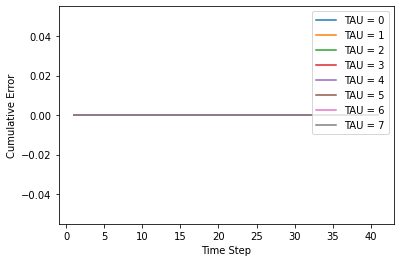

In [14]:
'''
More data processing
'''
# sum up the negative costs for the tower (get total expiration value)
cost_per_tau_over_time = [[] for i in range(TAU_MAX)]
for index,tau in enumerate(completed_states):
    sum_cost = 0
    for time_step in range(len(completed_states[0][0])):
        for tower in tau:
            for expiration in tower[time_step].time_vector:
                if expiration < 0:
                    sum_cost -= expiration 
#                     sum_cost +=1
        cost_per_tau_over_time[index].append(sum_cost)
cost_per_tau_over_time = cost_per_tau_over_time
'''
first plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
'''
import matplotlib.pyplot as plt
x = [i+1 for i in range(len(completed_states[0][0]))]
for tau_num, tau in enumerate(cost_per_tau_over_time):
    plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cumulative Error')
plt.show()


[2, 2, 3, 5, 5, 5, 7, 13, 14, 16, 17, 18, 19, 21, 21, 23, 23, 24, 24, 24, 25, 26, 27, 30, 32, 33, 33, 35, 35, 36, 38, 44, 45, 45, 46, 47, 48, 48, 50, 55, 0]


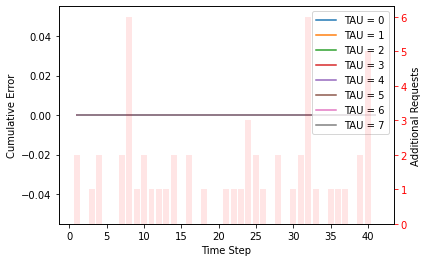

In [15]:
'''
second plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
also include a line for the traffic over time
'''
cum_input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    if time_step > 0:
        cum_input_len_over_time[time_step] = cum_input_len_over_time[time_step-1]  
    for key in input[time_step][0].keys():
        cum_input_len_over_time[time_step] += len(input[time_step][0][key])
print (cum_input_len_over_time)
for i in range(len(input), len(x)):
    cum_input_len_over_time[i] = cum_input_len_over_time[i-1]

fig,ax1 = plt.subplots()
# print (cost_per_tau_over_time[4])
for tau_num, tau in enumerate(cost_per_tau_over_time):
    ax1.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cumulative Error')
input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    for key in input[time_step][0].keys():
        input_len_over_time[time_step] += len(input[time_step][0][key])
ax2 = ax1.twinx()
ax2.bar(x, input_len_over_time, color='r', alpha=0.1)
# ax2.plot(x, cum_input_len_over_time, 'r.')
ax2.set_ylabel('Additional Requests')
ax2.tick_params('y',colors='r')
plt.savefig('data/Realtime/cumulative_error_over_time_with_requests' + str(index) + '.png',dpi=216)

<BarContainer object of 41 artists>

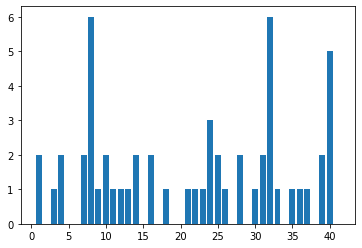

In [16]:
'''
second plot:
traffic over time
'''
input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    for key in input[time_step][0].keys():
        input_len_over_time[time_step] += len(input[time_step][0][key])
plt.bar(x, input_len_over_time)


In [17]:
'''
timings data
'''
for timings in timing_info:
#     print(timings)
    print(sum(timings))

7.637950344986166
6.806180026011134
6.757255049997184
6.759990213024139
6.8329651479944005
6.837024547989131
7.067194335024396
8.19666425401374
